# InSituPy demonstration - Investigate gene expression along an axis using kernel densities

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
import mellon
import palantir
import numpy as np
import pandas as pd

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [4]:
insitupy_project = Path("demo_dataset/demo_insitupy_project")

In [5]:
xd = read_xenium(insitupy_project)
xd.load_images()
xd.load_cells()

Loading images...
['nuclei', 'CD20', 'HER2', 'DAPI', 'HE']
Loading cells...
	No alternative cells found...


In [6]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'spatial'
           varm: 'OT', 'PCs', 'binned_expression'
           layers: 'counts', 'norm_counts'
           obsp: 'connec

## Calculate distance of cells to annotations

To generate an axis we use here a selected set of annotations and calculate the distance of all cells to these annotations. For demonstration purposes we selected a region of the breast cancer dataset and annotated tumor cells within this region:
<center><img src="./demo_screenshots/tumor_region_annotation_example.png" width="600"/></center>

These annotations and the region can be imported from files in the repository but of course it would be also possible to do own annotations and select an own region and save the results using `.store_geometries()`.

In [7]:
from insitupy import calc_distance_of_cells_from

In [8]:
xd.import_annotations(
    files="./demo_annotations/annotations-Tumor.geojson",
    keys="Tumor"
)

Importing annotations...


In [9]:
xd.import_annotations(
    files="./demo_annotations/demo_annotations.geojson",
    keys="Demo"
)

Importing annotations...


In [10]:
xd.import_annotations(
    files="./demo_annotations/demo_points.geojson",
    keys="Demo"
)

Importing annotations...


In [11]:
xd.import_regions(
    files="./demo_regions/regions-Tumor.geojson",
    keys="Tumor"
)

Importing regions...


In [12]:
calc_distance_of_cells_from(
    data=xd,
    annotation_key="Demo",
    annotation_class="Tumor center",
    # region_key="Tumor",
    # region_name="Selected Tumor"
)

Calculate the distance of cells from the annotation "Tumor center"
Saved distances to `.cells.matrix.obsm["distance_from"]["Tumor center"]`


In [13]:
xd.cells.matrix.obsm["distance_from"]

Tumor center
1        2480.161784
2        2487.117058
5        2477.066531
8        2473.688216
9        2463.314224
...              ...
167776   3175.216840
167777   3200.067398
167778   3190.414884
167779   3201.076376
167780   3209.733931

[163565 rows x 1 columns]

In [14]:
mask = xd.cells.matrix.obsm["distance_from"]["Tumor center"].notna()
xd.cells.matrix.obsm["distance_from"]["Tumor center"][mask]

1         2480.161784
2         2487.117058
5         2477.066531
8         2473.688216
9         2463.314224
             ...     
167776    3175.216840
167777    3200.067398
167778    3190.414884
167779    3201.076376
167780    3209.733931
Name: Tumor center, Length: 163565, dtype: float64

### Visualize the results using `napari`

Using `.show()` we can visualize the results and see the distance values per cell:
<center><img src="./demo_screenshots/distances_from_tumor_example.jpg" width="200"/></center>


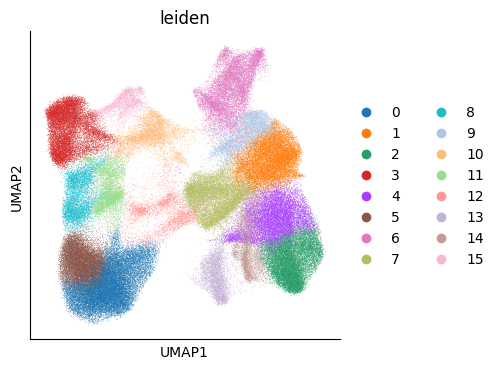

In [15]:
import scanpy as sc
sc.pl.umap(adata=xd.cells.matrix, color="leiden")

## Select small region for testing

In [16]:
xdcrop = xd.crop(region_tuple=("Tumor", "Selected Tumor"))
adata = xdcrop.cells.matrix

## Calculate density using kernel density or `Mellon`

In [17]:
from insitupy.utils._calc import calc_grouped_log_density

In [18]:

# Example usage
calc_grouped_log_density(
    adata,
    groupby='cell_type',
    mode="gauss",
    inplace=True)

100%|██████████| 18/18 [00:03<00:00,  5.38it/s]


In [19]:
# Example usage
calc_grouped_log_density(
    adata,
    groupby='cell_type',
    mode="mellon",
    inplace=True)


  0%|          | 0/18 [00:00<?, ?it/s]

[2024-11-05 09:42:38,981] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (4,399) >= n_samples (4,399) and rank = 1.0.
[2024-11-05 09:42:38,982] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:42:39,356] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:42:39,760] [INFO    ] Using covariance function Matern52(ls=239.44837480917).
[2024-11-05 09:42:42,137] [INFO    ] Using rank 4,399 covariance representation.
[2024-11-05 09:42:43,650] [INFO    ] Running inference using L-BFGS-B.


  6%|▌         | 1/18 [00:07<02:08,  7.56s/it]

[2024-11-05 09:42:46,472] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (735) >= n_samples (735) and rank = 1.0.
[2024-11-05 09:42:46,474] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:42:46,727] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:42:46,939] [INFO    ] Using covariance function Matern52(ls=355.4349887523831).
[2024-11-05 09:42:47,856] [INFO    ] Using rank 735 covariance representation.
[2024-11-05 09:42:47,972] [INFO    ] Running inference using L-BFGS-B.


 11%|█         | 2/18 [00:10<01:12,  4.55s/it]

[2024-11-05 09:42:48,920] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (585) >= n_samples (585) and rank = 1.0.
[2024-11-05 09:42:48,921] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:42:49,174] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:42:49,336] [INFO    ] Using covariance function Matern52(ls=311.61934463569906).
[2024-11-05 09:42:50,261] [INFO    ] Using rank 585 covariance representation.
[2024-11-05 09:42:50,369] [INFO    ] Running inference using L-BFGS-B.


 17%|█▋        | 3/18 [00:12<00:52,  3.51s/it]

[2024-11-05 09:42:51,188] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (539) >= n_samples (539) and rank = 1.0.
[2024-11-05 09:42:51,189] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:42:51,435] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:42:51,596] [INFO    ] Using covariance function Matern52(ls=404.20186883004015).
[2024-11-05 09:42:52,513] [INFO    ] Using rank 539 covariance representation.
[2024-11-05 09:42:52,641] [INFO    ] Running inference using L-BFGS-B.


 22%|██▏       | 4/18 [00:14<00:43,  3.12s/it]

[2024-11-05 09:42:53,703] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (5,252) and rank = 1.0.
[2024-11-05 09:42:53,705] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:42:54,040] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:42:54,227] [INFO    ] Using covariance function Matern52(ls=196.37242964432804).
[2024-11-05 09:42:54,229] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-11-05 09:43:01,271] [INFO    ] Using rank 5,000 covariance representation.
[2024-11-05 09:43:03,138] [INFO    ] Running inference using L-BFGS-B.


 28%|██▊       | 5/18 [00:27<01:26,  6.67s/it]

[2024-11-05 09:43:06,667] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (2,304) >= n_samples (2,304) and rank = 1.0.
[2024-11-05 09:43:06,668] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:06,930] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:07,100] [INFO    ] Using covariance function Matern52(ls=337.37727877805037).
[2024-11-05 09:43:08,214] [INFO    ] Using rank 2,304 covariance representation.
[2024-11-05 09:43:08,616] [INFO    ] Running inference using L-BFGS-B.


 33%|███▎      | 6/18 [00:31<01:08,  5.69s/it]

[2024-11-05 09:43:10,457] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (8,633) and rank = 1.0.
[2024-11-05 09:43:10,459] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:10,830] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:11,064] [INFO    ] Using covariance function Matern52(ls=293.46151061703705).
[2024-11-05 09:43:11,067] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-11-05 09:43:18,336] [INFO    ] Using rank 5,000 covariance representation.
[2024-11-05 09:43:20,617] [INFO    ] Running inference using L-BFGS-B.


 39%|███▉      | 7/18 [00:45<01:32,  8.43s/it]

[2024-11-05 09:43:24,519] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (1,295) >= n_samples (1,295) and rank = 1.0.
[2024-11-05 09:43:24,520] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:24,781] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:24,941] [INFO    ] Using covariance function Matern52(ls=362.90922766565643).
[2024-11-05 09:43:25,799] [INFO    ] Using rank 1,295 covariance representation.
[2024-11-05 09:43:25,952] [INFO    ] Running inference using L-BFGS-B.


 44%|████▍     | 8/18 [00:48<01:06,  6.66s/it]

[2024-11-05 09:43:27,405] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (178) >= n_samples (178) and rank = 1.0.
[2024-11-05 09:43:27,406] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:27,703] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:27,908] [INFO    ] Using covariance function Matern52(ls=754.8453492752406).
[2024-11-05 09:43:29,154] [INFO    ] Using rank 178 covariance representation.
[2024-11-05 09:43:29,258] [INFO    ] Running inference using L-BFGS-B.


 50%|█████     | 9/18 [00:51<00:48,  5.41s/it]

[2024-11-05 09:43:30,074] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (58) >= n_samples (58) and rank = 1.0.
[2024-11-05 09:43:30,076] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:30,319] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:30,487] [INFO    ] Using covariance function Matern52(ls=2720.4988672303475).
[2024-11-05 09:43:31,221] [INFO    ] Using rank 58 covariance representation.
[2024-11-05 09:43:31,315] [INFO    ] Running inference using L-BFGS-B.


 56%|█████▌    | 10/18 [00:53<00:34,  4.32s/it]

[2024-11-05 09:43:31,952] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (150) >= n_samples (150) and rank = 1.0.
[2024-11-05 09:43:31,954] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:32,205] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:32,369] [INFO    ] Using covariance function Matern52(ls=1040.5173654213668).
[2024-11-05 09:43:33,226] [INFO    ] Using rank 150 covariance representation.
[2024-11-05 09:43:33,335] [INFO    ] Running inference using L-BFGS-B.


 61%|██████    | 11/18 [00:55<00:25,  3.67s/it]

[2024-11-05 09:43:34,151] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (74) >= n_samples (74) and rank = 1.0.
[2024-11-05 09:43:34,152] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:34,423] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:34,589] [INFO    ] Using covariance function Matern52(ls=1655.3290584117442).
[2024-11-05 09:43:35,347] [INFO    ] Using rank 74 covariance representation.
[2024-11-05 09:43:35,455] [INFO    ] Running inference using L-BFGS-B.


 67%|██████▋   | 12/18 [00:57<00:18,  3.17s/it]

[2024-11-05 09:43:36,154] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (1,064) >= n_samples (1,064) and rank = 1.0.
[2024-11-05 09:43:36,156] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:36,412] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:36,572] [INFO    ] Using covariance function Matern52(ls=232.85032589086492).
[2024-11-05 09:43:37,454] [INFO    ] Using rank 1,064 covariance representation.
[2024-11-05 09:43:37,632] [INFO    ] Running inference using L-BFGS-B.


 72%|███████▏  | 13/18 [00:59<00:14,  2.96s/it]

[2024-11-05 09:43:38,650] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (10) >= n_samples (10) and rank = 1.0.
[2024-11-05 09:43:38,651] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:38,955] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:39,116] [INFO    ] Using covariance function Matern52(ls=5370.741271655917).
[2024-11-05 09:43:39,895] [INFO    ] Using rank 10 covariance representation.
[2024-11-05 09:43:40,000] [INFO    ] Running inference using L-BFGS-B.


 78%|███████▊  | 14/18 [01:01<00:10,  2.66s/it]

[2024-11-05 09:43:40,612] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (19) >= n_samples (19) and rank = 1.0.
[2024-11-05 09:43:40,613] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:40,859] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:41,016] [INFO    ] Using covariance function Matern52(ls=3287.047799427375).
[2024-11-05 09:43:41,751] [INFO    ] Using rank 19 covariance representation.
[2024-11-05 09:43:41,854] [INFO    ] Running inference using L-BFGS-B.


 83%|████████▎ | 15/18 [01:03<00:07,  2.44s/it]

[2024-11-05 09:43:42,535] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (47) >= n_samples (47) and rank = 1.0.
[2024-11-05 09:43:42,536] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:42,792] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:42,951] [INFO    ] Using covariance function Matern52(ls=1517.943187234375).
[2024-11-05 09:43:43,695] [INFO    ] Using rank 47 covariance representation.
[2024-11-05 09:43:43,789] [INFO    ] Running inference using L-BFGS-B.


 89%|████████▉ | 16/18 [01:05<00:04,  2.29s/it]

[2024-11-05 09:43:44,467] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (99) >= n_samples (99) and rank = 1.0.
[2024-11-05 09:43:44,468] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:44,725] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:44,884] [INFO    ] Using covariance function Matern52(ls=1095.5308088746292).
[2024-11-05 09:43:45,613] [INFO    ] Using rank 99 covariance representation.
[2024-11-05 09:43:45,721] [INFO    ] Running inference using L-BFGS-B.


 94%|█████████▍| 17/18 [01:07<00:02,  2.20s/it]

[2024-11-05 09:43:46,463] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (2) >= n_samples (2) and rank = 1.0.
[2024-11-05 09:43:46,465] [INFO    ] Computing nearest neighbor distances.
[2024-11-05 09:43:46,666] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-11-05 09:43:46,809] [INFO    ] Using covariance function Matern52(ls=35080.27609941753).
[2024-11-05 09:43:47,476] [INFO    ] Using rank 2 covariance representation.
[2024-11-05 09:43:47,592] [INFO    ] Running inference using L-BFGS-B.


100%|██████████| 18/18 [01:09<00:00,  3.85s/it]


In [20]:
from insitupy import CustomPalettes
import matplotlib.pyplot as plt

In [21]:
from insitupy._constants import DEFAULT_CATEGORICAL_CMAP

In [22]:
from insitupy.plotting import cell_abundance_along_obs_val

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:761: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.histplot(data=data, x=obs_val,


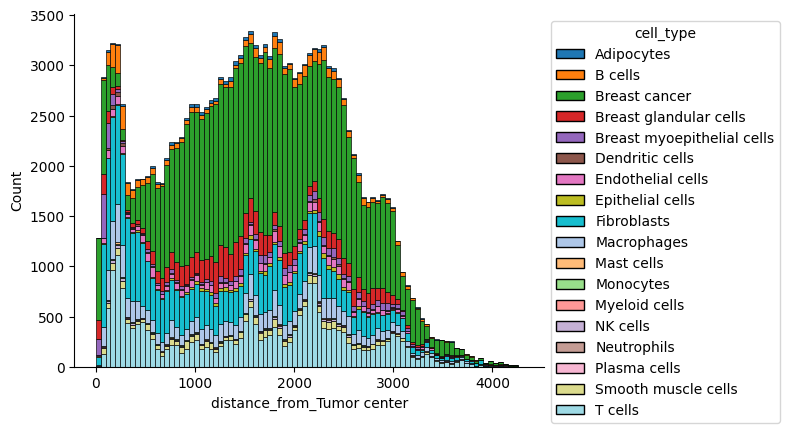

In [23]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    #xlim=(0,400),
    figsize=(8,4.5), kde=False
)

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:767: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.kdeplot(data=data, x=obs_val,


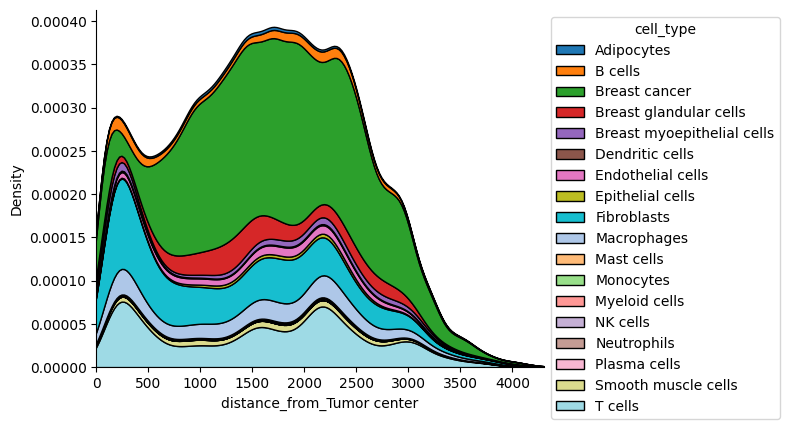

In [24]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    #xlim=(0,400),
    figsize=(8,4.5), kde=True
)

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:761: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.histplot(data=data, x=obs_val,


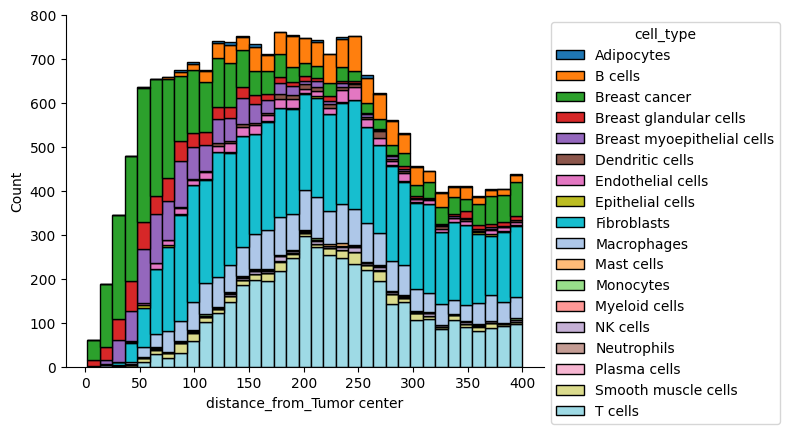

In [25]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    xlim=(0,400),
    figsize=(8,4.5), kde=False
)

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:767: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.kdeplot(data=data, x=obs_val,


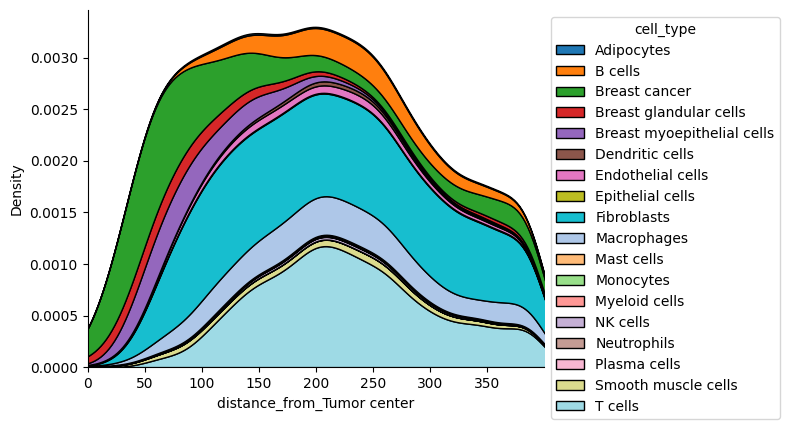

In [26]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor center"),
    groupby="cell_type",
    xlim=(0,400),
    figsize=(8,4.5), kde=True
)

Retrieve `obs_val` from .obsm.


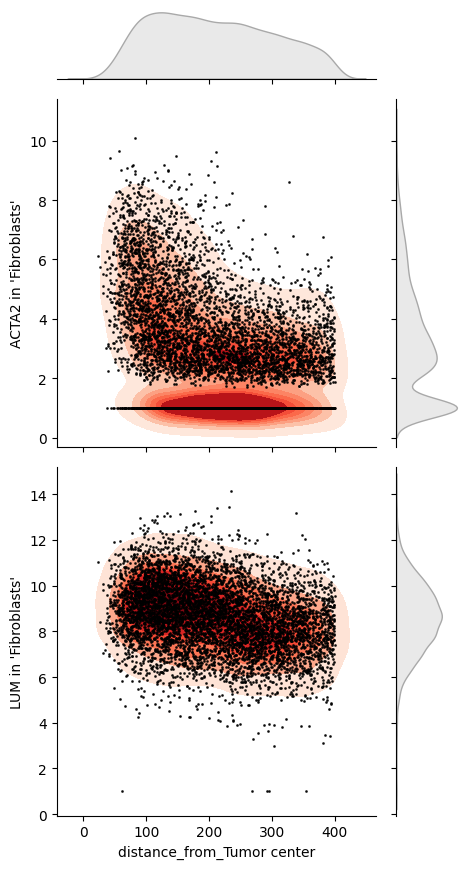

In [27]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    genes=["ACTA2", "LUM"],
    xlim=(0, 400),
    #min_expression=1.5
    )


# How can we identify significant patterns?

In the SPATA2 paper they work with a metric they call total variation (TV):
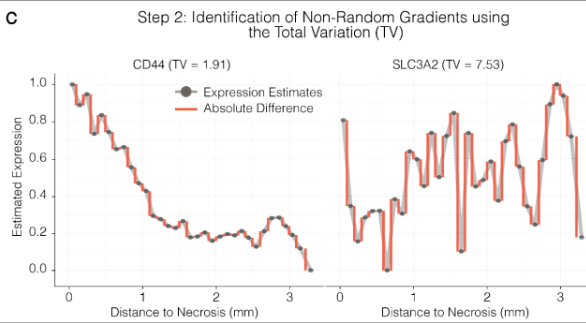
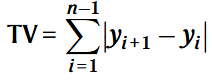

And the significance of a pattern they calculate with following formular:
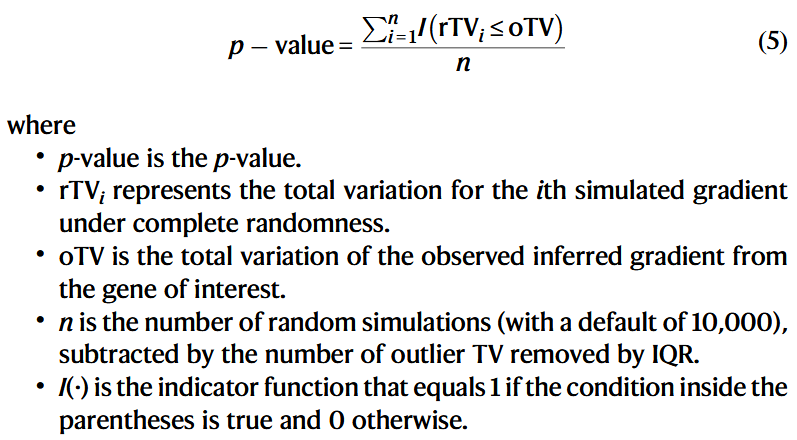

## Using SPATA2 method

### In the method they used the "expression estimates" which seems to be the results of the loess regression:
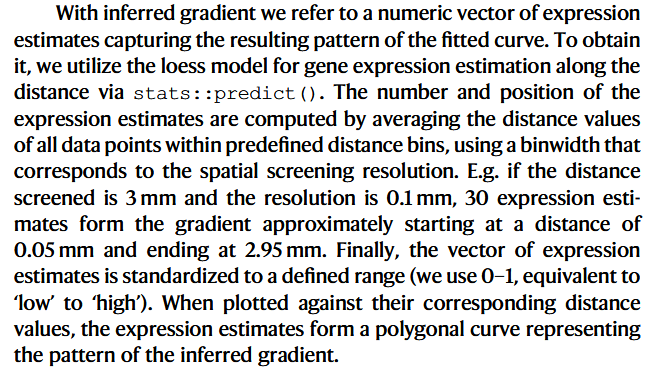

In [41]:
from insitupy.plotting.expression_along_axis import _select_data
from insitupy.plotting.expression_along_axis import _bin_data
from insitupy.utils._patterns import calculate_total_variation_pval
from sklearn.preprocessing import MinMaxScaler

In [30]:
gene = "ACTA2"
data = _select_data(adata=adata,
             obs_val=("distance_from", "Tumor center"),
             genes=gene, cell_type_column="cell_type",
             cell_type="Fibroblasts", xlim=(0,400),
             min_expression=1.5
             )

Retrieve `obs_val` from .obsm.


In [34]:
_bin_data(
    data=data, resolution=5, plot=False
    )

ACTA2
26.3395   1.000000
31.5405   0.759141
36.5535   0.654163
41.5665   0.832485
46.5790   0.758975
...            ...
377.4240  0.085300
382.4365  0.141148
387.4495  0.250650
392.4625  0.121283
397.4755  0.054556

[75 rows x 1 columns]

In [82]:
genes = ["ACTA2", "LUM", "CRHBP"]
data = _select_data(adata=adata,
             obs_val=("distance_from", "Tumor center"),
             genes=genes, cell_type_column="cell_type",
             cell_type="Fibroblasts", xlim=(0,400),
             min_expression=1.5,
             )


Retrieve `obs_val` from .obsm.


In [83]:
data

ACTA2       LUM  CRHBP
cell_id axis       cell_type                             
106797  24.021389  Fibroblasts  0.524889  0.724651    NaN
106815  26.743697  Fibroblasts  0.481048  0.488491    NaN
105783  31.364094  Fibroblasts  0.453237  0.614802    NaN
105693  31.573397  Fibroblasts  0.403747  0.367432    NaN
106824  31.587514  Fibroblasts  0.376833  0.634900    NaN
...                                  ...       ...    ...
7389    398.987894 Fibroblasts  0.177372  0.464550    NaN
7403    399.047868 Fibroblasts  0.040858  0.418665    NaN
55224   399.533768 Fibroblasts       NaN  0.491646    NaN
107721  399.554784 Fibroblasts  0.020338  0.589779    NaN
77440   399.981713 Fibroblasts       NaN  0.397011    NaN

[6104 rows x 3 columns]

In [85]:
data.index.get_level_values("axis").values

array([ 24.02138913,  26.74369691,  31.36409402, ..., 399.5337683 ,
       399.55478367, 399.98171336])

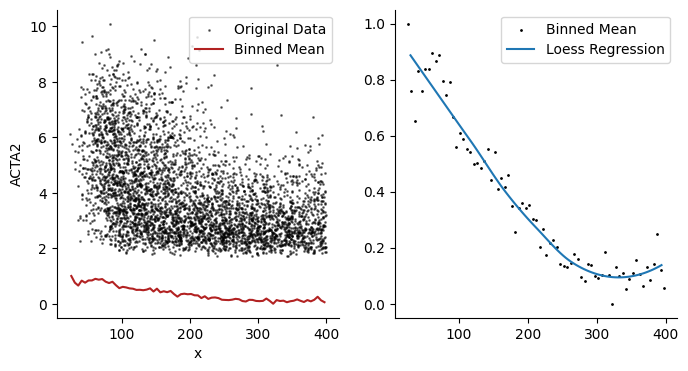

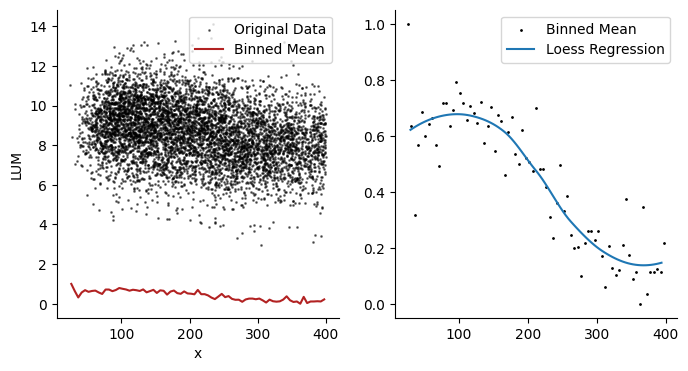

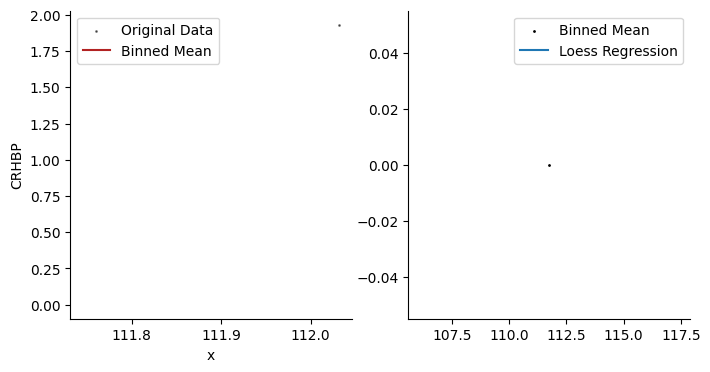

In [39]:
binned_mean = _bin_data(data=data, resolution=5, plot=True)

In [40]:
binned_mean

ACTA2       LUM  CRHBP
26.3395   1.000000  1.000000    NaN
31.5405   0.759141  0.633014    NaN
36.5535   0.654163  0.316707    NaN
41.5665   0.832485  0.567257    NaN
46.5790   0.758975  0.684047    NaN
...            ...       ...    ...
377.4240  0.085300  0.112358    NaN
382.4365  0.141148  0.113577    NaN
387.4495  0.250650  0.125599    NaN
392.4625  0.121283  0.113989    NaN
397.4755  0.054556  0.218577    NaN

[75 rows x 3 columns]

In [127]:
data.index

Index(['106797', '106815', '105783', '105693', '106824', '117508', '105764',
       '117700', '105692', '105699',
       ...
       '106524', '7667', '77377', '74227', '93069', '7389', '7403', '55224',
       '107721', '77440'],
      dtype='object', length=6104)

In [80]:
pval = calculate_total_variation_pval(
    adata=adata,
    genes="LUM",
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type", cell_type="Fibroblasts", xlim=(0,400),
    bin_data=True, resolution=5,
    parallel=True, n_sim=100, min_expression=1.5
    )

  0%|          | 0/1 [00:00<?, ?it/s]

LUM


In [ ]:
pval = calculate_total_variation_pval(
    adata=adata,
    gene="ACTA2",
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type", cell_type="Fibroblasts", xlim=(0,400),
    bin_data=True, resolution=100,
    parallel=True, n_sim=10000, min_expression=1.5
    )

Retrieve `obs_val` from .obsm.


In [182]:
pval = calculate_total_variation_pval(
    adata=adata,
    genes=["ACTA2", "LUM"],
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type", cell_type="Fibroblasts", xlim=(0,400),
    bin_data=True, resolution=5,
    parallel=True, n_sim=10000, min_expression=1.5,
    n_jobs=8
    )

  0%|          | 0/2 [00:00<?, ?it/s]

Retrieve `obs_val` from .obsm.
Retrieve `obs_val` from .obsm.


In [184]:
genes = list(adata.var_names)

In [190]:
pvals = calculate_total_variation_pval(
    adata=adata,
    genes=genes,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type", cell_type="Fibroblasts", xlim=(0,400),
    bin_data=True, resolution=5,
    parallel=True, n_sim=10000, min_expression=1.5,
    n_jobs=8
    )

  0%|          | 0/313 [00:00<?, ?it/s]

ABCC11
ACTA2
ACTG2
ADAM9
ADGRE5
ADH1B
ADIPOQ
AGR3
AHSP
AIF1
AKR1C1
AKR1C3
ALDH1A3
ANGPT2
ANKRD28
ANKRD29
ANKRD30A
APOBEC3A
APOBEC3B
APOC1
AQP1
AQP3
AR
AVPR1A
BACE2
BANK1
BASP1
BTNL9
C15orf48
C1QA
C1QC
C2orf42
C5orf46
C6orf132
CAV1
CAVIN2
CCDC6
CCDC80
CCL20
CCL5
CCL8
CCND1
CCPG1
CCR7
CD14
CD163
CD19
CD1C
CD247
CD27
CD274
CD3D
CD3E
CD3G
CD4
CD68
CD69
CD79A
CD79B
CD80
CD83
CD86
CD8A
CD8B
CD9
CD93
CDC42EP1
CDH1
CEACAM6
CEACAM8
CENPF
CLCA2
CLDN4
CLDN5
CLEC14A
CLEC9A
CLECL1
CLIC6
CPA3
CRHBP


ValueError: `bins` should be a positive integer.

# Error with "CRHBP"

In [204]:
gene = "CRHBP"
data = _select_data(adata=adata,
             obs_val=("distance_from", "Tumor center"),
             gene=gene, cell_type_column="cell_type",
             cell_type="Fibroblasts", xlim=(0,400),
             min_expression=1.5

             )

Retrieve `obs_val` from .obsm.


# Important to do the nbins calculation before _bin_data in that case. With min_expression lots of cells are sorted out and then the resolution gives different results depending on which and how many genes are still present

# Instead of sorting out the min_expression values, rather set them to NaN?

In [205]:
data

axis    cell_type     CRHBP
78680  112.031773  Fibroblasts  1.931852

In [ ]:

_bin_data(expr=data[gene], axis=data["axis"], resolution=5, plot=True)

In [194]:
data

axis    cell_type  CRHBP
106797   24.021389  Fibroblasts    1.0
106815   26.743697  Fibroblasts    1.0
105783   31.364094  Fibroblasts    1.0
105693   31.573397  Fibroblasts    1.0
106824   31.587514  Fibroblasts    1.0
...            ...          ...    ...
7389    398.987894  Fibroblasts    1.0
7403    399.047868  Fibroblasts    1.0
55224   399.533768  Fibroblasts    1.0
107721  399.554784  Fibroblasts    1.0
77440   399.981713  Fibroblasts    1.0

[6104 rows x 3 columns]

In [178]:
pval

ACTA2    0.0
LUM      0.0
dtype: float64

In [ ]:
from tqdm.auto import tqdm
def run1(genes):
    return np.array([calculate_total_variation_pval(
        adata=adata,
        gene=gene,
        obs_val=("distance_from", "Tumor center"),
        cell_type_column="cell_type", cell_type="Fibroblasts", xlim=(0,400),
        bin_data=True, resolution=5,
        parallel=True, n_sim=100, min_expression=1.5
        ) for gene in tqdm(genes)])

# def run2(genes):
#     return np.array(Parallel(n_jobs=16)(delayed(calculate_total_variation_pval)(
#         _adata, ("distance_from", "Tumor center"), gene,
#         "cell_type", "Fibroblasts", (0,400), False, True, 100, 1000
#         ) for gene in tqdm(genes)))

In [ ]:
pvals = run1(genes)

  0%|          | 0/313 [00:00<?, ?it/s]

Retrieve `obs_val` from .obsm.
401
Retrieve `obs_val` from .obsm.
4350
Retrieve `obs_val` from .obsm.
3974
Retrieve `obs_val` from .obsm.
3386
Retrieve `obs_val` from .obsm.
1620
Retrieve `obs_val` from .obsm.
992
Retrieve `obs_val` from .obsm.
85
Retrieve `obs_val` from .obsm.
280
Retrieve `obs_val` from .obsm.
16
Retrieve `obs_val` from .obsm.
2702
Retrieve `obs_val` from .obsm.
916
Retrieve `obs_val` from .obsm.
542
Retrieve `obs_val` from .obsm.
1016
Retrieve `obs_val` from .obsm.
419
Retrieve `obs_val` from .obsm.
1181
Retrieve `obs_val` from .obsm.
293
Retrieve `obs_val` from .obsm.
2218
Retrieve `obs_val` from .obsm.
50
Retrieve `obs_val` from .obsm.
528
Retrieve `obs_val` from .obsm.
805
Retrieve `obs_val` from .obsm.
1615
Retrieve `obs_val` from .obsm.
405
Retrieve `obs_val` from .obsm.
786
Retrieve `obs_val` from .obsm.
166
Retrieve `obs_val` from .obsm.
2257
Retrieve `obs_val` from .obsm.
619
Retrieve `obs_val` from .obsm.
4625
Retrieve `obs_val` from .obsm.
668
Retrieve `ob

KeyboardInterrupt: 

In [ ]:
import numpy as np
from insitupy.utils._regression import smooth_fit

In [ ]:
adata = xdcrop.cells.matrix

In [ ]:
adata

AnnData object with n_obs × n_vars = 25443 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'OT', 'X_pca', 'X_umap', 'spatial', 'distance_from', 'density-gauss', 'density_clipped-gauss', 'density-mellon', 'density_clipped-mellon'
    varm: 'OT', 'PCs', 'binned_expression'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [ ]:
from tqdm import tqdm
from joblib import delayed, Parallel
import seaborn as sns
from insitupy.plotting.expression_along_axis import _select_data
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# parameters
gene = "ACTA2"
nbins = 100

data = _select_data(adata=adata,
             obs_val=("distance_from", "Tumor center"),
             genes=gene, cell_type_column="cell_type",
             cell_type="Fibroblasts", xlim=(0,400)
             )
data = data.sort_values("axis")
data["bin"] = pd.cut(data["axis"], bins=nbins)
binned_mean = data.groupby("bin")[gene].mean()
binned_mean = binned_mean.reset_index()
scaler = MinMaxScaler()
binned_mean["minmax"] = scaler.fit_transform(binned_mean[[gene]])
binned_mean["bin_center"] = [elem.mid for elem in binned_mean["bin"]]

Retrieve `obs_val` from .obsm.


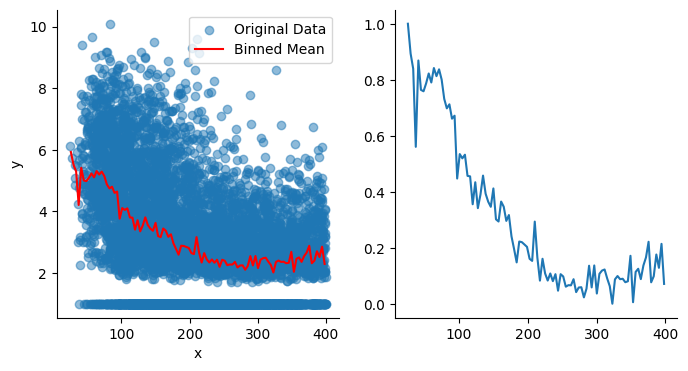

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
# Plot the original data
axs[0].scatter(data["axis"], data[gene], label='Original Data', alpha=0.5)

# Plot the binned values
axs[0].plot(binned_mean["bin_center"],
         binned_mean[gene],
         color='red',
         #marker='o',
         linestyle='-', label='Binned Mean')

# Add labels and legend
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[0].legend()

axs[1].plot(binned_mean["bin_center"], binned_mean["minmax"])

# Show plot
plt.show()

Retrieve `obs_val` from .obsm.


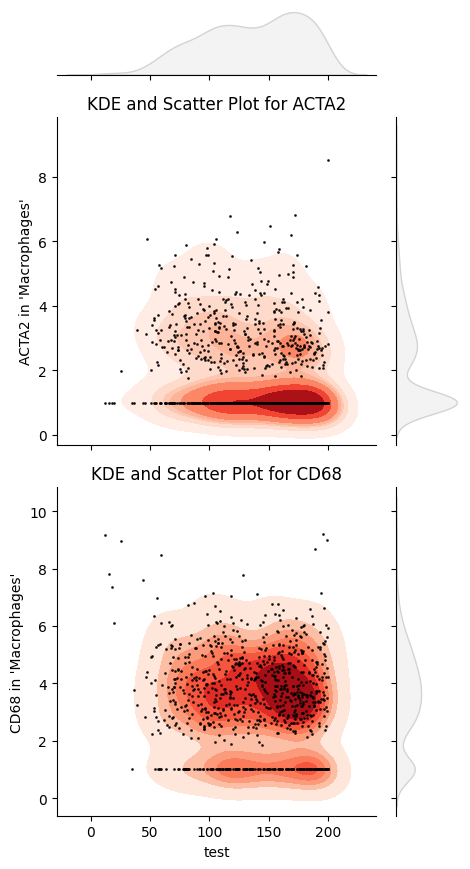

In [152]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Macrophages",
    genes=["ACTA2", "CD68"],
    xlim=(0, 200),
    xlabel="test",
    #min_expression=1.5
    )


In [ ]:
pvals = run2(genes)

  0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# Functions
def total_variation(values):
    return np.sum(np.abs(np.diff(values)))

# def binned_total_variation(expr, axis, resolution=5):
#     # calculate number of bins from resolution
#     nbins = int((axis.max() - axis.min()) / resolution)

#     data = pd.DataFrame(
#         {"axis": axis,
#          "expr": expr}
#     )

#     # bin data and calculate mean per bin
#     data["bin"] = pd.cut(data["axis"], bins=nbins)
#     binned_mean = data.groupby("bin")["expr"].mean()
#     binned_mean = binned_mean.reset_index()

#     # remove empty bins
#     binned_mean = binned_mean.dropna()

#     # scale values to 0-1
#     scaler = MinMaxScaler()
#     binned_mean["minmax"] = scaler.fit_transform(binned_mean[["expr"]])

#     # extract the center of each bin
#     binned_mean["bin_center"] = [elem.mid for elem in binned_mean["bin"]]
#     expr = binned_mean["expr"].values
#     return total_variation(expr)

def random_permutation_tv(expr):
    # Create an array with values from 0 to 10
    random_order = np.random.permutation(np.arange(len(expr)))
    expr_random = expr[random_order]

    return total_variation(expr_random)

# def random_permutation_tv(expr, axis, bin_data, resolution):
#     # Create an array with values from 0 to 10
#     random_order = np.random.permutation(np.arange(len(expr)))
#     expr_random = expr[random_order]

#     if bin_data:
#         tv = binned_total_variation(expr=expr_random, axis=axis, resolution=resolution)
#     else:
#         tv = total_variation(expr_random)

#     return tv

# def random_permutation_tv_precalc(expr, permutations):
#     expr_sorted = expr[permutations]
#     return total_variation(expr_sorted)'

def filter_outliers(data, threshold=1.5):
    """
    Remove values that lie significantly outside the IQR.

    Args:
        data (numpy.ndarray): The input array.
        threshold (float, optional): The multiplier for the IQR to define outliers. Default is 1.5.

    Returns:
        numpy.ndarray: The filtered array with outliers removed.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Filter the array to remove outliers
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

    return filtered_data



In [ ]:
from numbers import Number
from typing import Optional
def calculate_total_variation_pval(
    adata,
    obs_val,
    gene,
    cell_type_column,
    cell_type,
    xlim,
    parallel,
    bin_data: bool = False,
    resolution: Number = 5,
    n_sim: int = 10000,
    min_expression: Optional[Number] = None
    ):

    data = _select_data(adata=adata,
                obs_val=obs_val,
                genes=gene, cell_type_column=cell_type_column, cell_type=cell_type, xlim=xlim
                )
    data = data.sort_values("axis")

    # filter for minimum expression if threshold given
    if min_expression is not None:
        data = data[data[gene] >= min_expression].copy()
        print(len(data))

    # extract values necessary for further analysis
    expr_sorted = data[gene].values
    axis = data["axis"].values

    if bin_data:
        tv_gene = binned_total_variation(expr=expr_sorted, axis=axis, resolution=resolution)
    else:
        tv_gene = total_variation(values=expr_sorted)
    # simulation of random total variations
    # speed up computation with joblib
    if parallel:
        #random_tvs = np.array(Parallel(n_jobs=8)(delayed(random_permutation_tv)(expr_sorted) for _ in range(n_sim)))
        random_tvs = np.array(Parallel(n_jobs=8)(delayed(random_permutation_tv)(expr_sorted, axis, bin_data, resolution) for _ in range(n_sim)))
    else:
        random_tvs = np.array([random_permutation_tv(expr_sorted, axis, bin_data, resolution) for _ in range(n_sim)])
    random_tvs_filtered = filter_outliers(random_tvs)
    n = len(random_tvs_filtered)
    p_val = np.sum(random_tvs_filtered <= tv_gene) / n
    return p_val


## In the SPATA2 paper they use Benjamini-Hochberg to adjust the p-value and get the FDR

In [168]:
from scipy.stats import false_discovery_control
from statsmodels.stats.multitest import fdrcorrection

In [177]:
fdrcorr = fdrcorrection(pvals, is_sorted=False)
fdrs = fdrcorr[1]
rejected = fdrcorr[0]

In [179]:
rejected.sum()

8

In [176]:
pvals

array([0.91605456, 0.        , 0.00909091, 0.9159919 , 0.07142857,
       0.01128205, 0.58164354, 0.76310273, 0.3566879 , 0.36567926,
       0.17382413, 0.19294606, 0.6483971 , 0.83088235, 0.71047228,
       0.32481363, 0.4       , 1.        , 0.49369748, 0.69875776,
       0.80903491, 0.11318795, 0.36260331, 0.8210075 , 0.4071066 ,
       0.07660455, 0.84141414, 0.07135471, 0.13107822, 0.55025381,
       0.10569106, 0.28258603, 0.9706191 , 0.11404435, 0.75914634,
       0.50159067, 0.43117409, 0.06395939, 0.62738854, 0.58257345,
       0.01671891, 0.80327869, 0.72104733, 0.55636743, 0.00101937,
       0.21057986, 0.04916318, 0.04752066, 0.2402863 , 0.10216718,
       0.25738397, 0.08950617, 0.05209397, 0.03222453, 0.01842375,
       0.27189409, 0.04465213, 0.69968717, 0.06984127, 0.01378579,
       0.68958333, 0.0942623 , 0.48423194, 0.47455867, 0.93135246,
       0.94742268, 0.05797101, 0.57830092, 0.21849593, 0.08105263,
       0.91295117, 0.96256684, 0.83052632, 0.52256034, 0.05241

In [173]:
not_significant_genes = np.array(genes)[fdrs > 0.05]
significant_genes = np.array(genes)[fdrs <= 0.05]

In [174]:
len(not_significant_genes)

305

In [175]:
significant_genes

array(['ACTA2', 'CD14', 'CLEC9A', 'CXCL12', 'DPT', 'EDNRB', 'IL7R',
       'PPARG'], dtype='<U8')

Retrieve `obs_val` from .obsm.


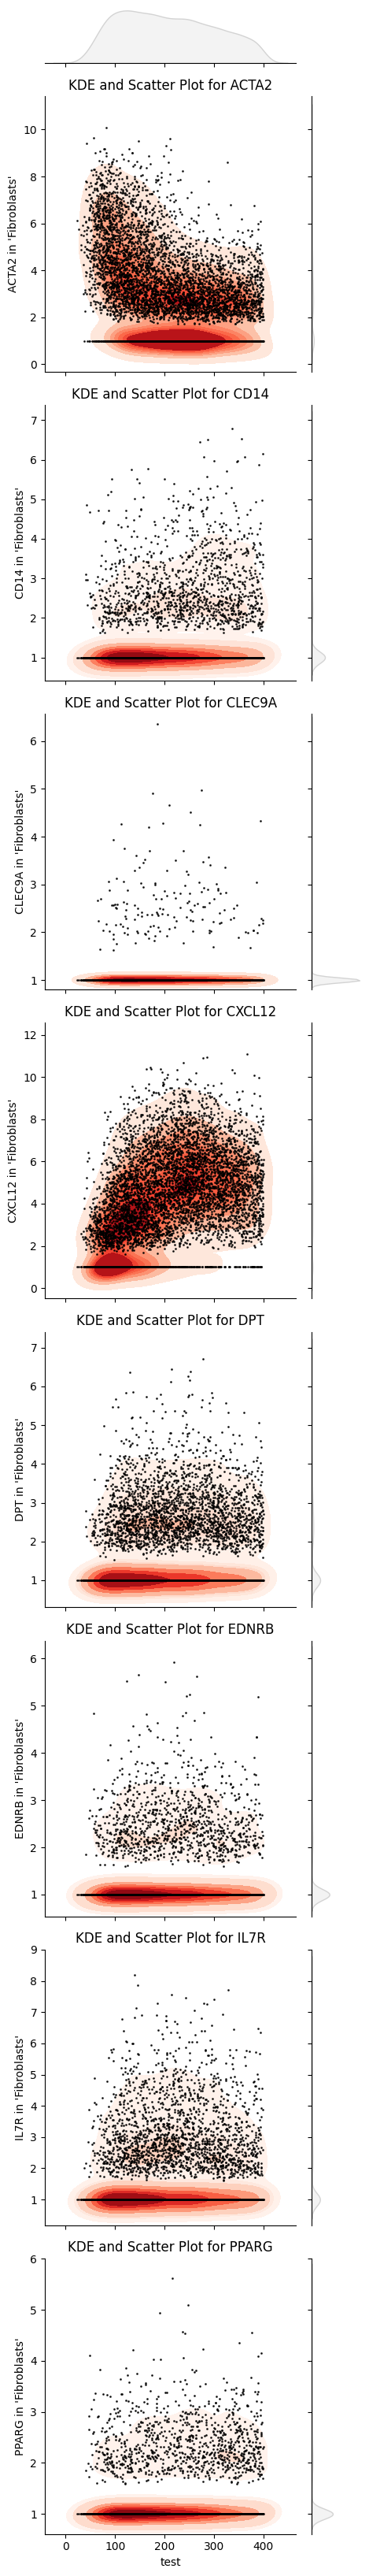

In [167]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    genes=significant_genes,
    xlim=(0, 400),
    xlabel="test",
    #min_expression=1.5
    )


Retrieve `obs_val` from .obsm.


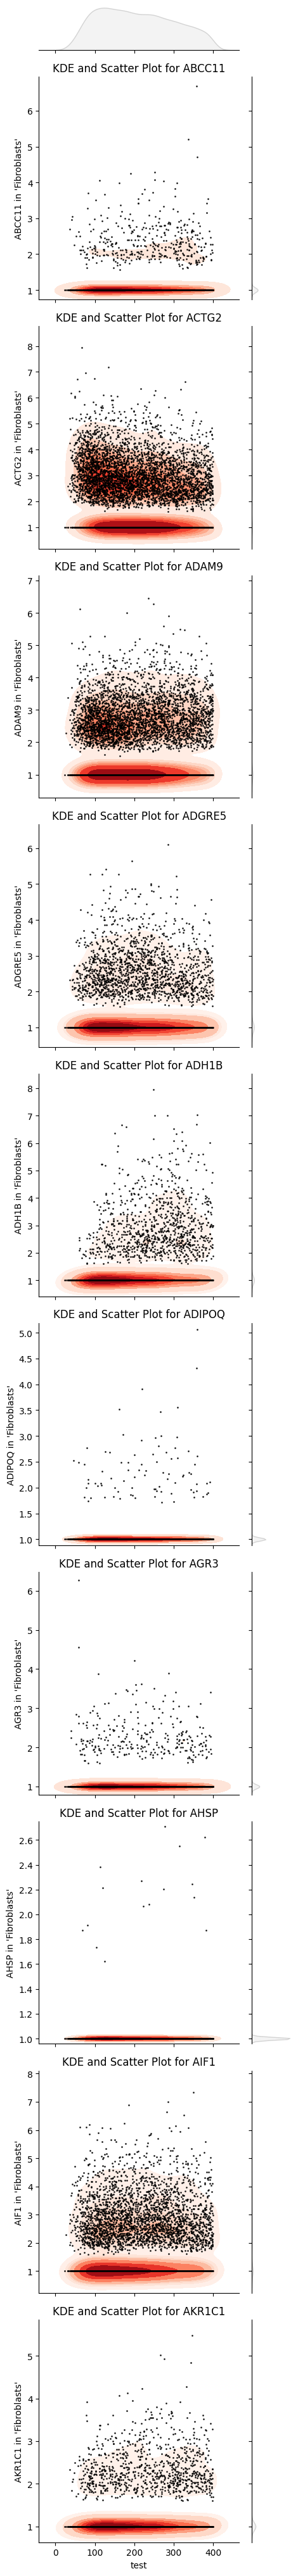

In [180]:
from insitupy.plotting import cell_expression_along_axis

# Example usage:
cell_expression_along_axis(
    adata=adata,
    obs_val=("distance_from", "Tumor center"),
    cell_type_column="cell_type",
    cell_type="Fibroblasts",
    genes=not_significant_genes[:10],
    xlim=(0, 400),
    xlabel="test",
    #min_expression=1.5
    )


Retrieve `obs_val` from .obsm.


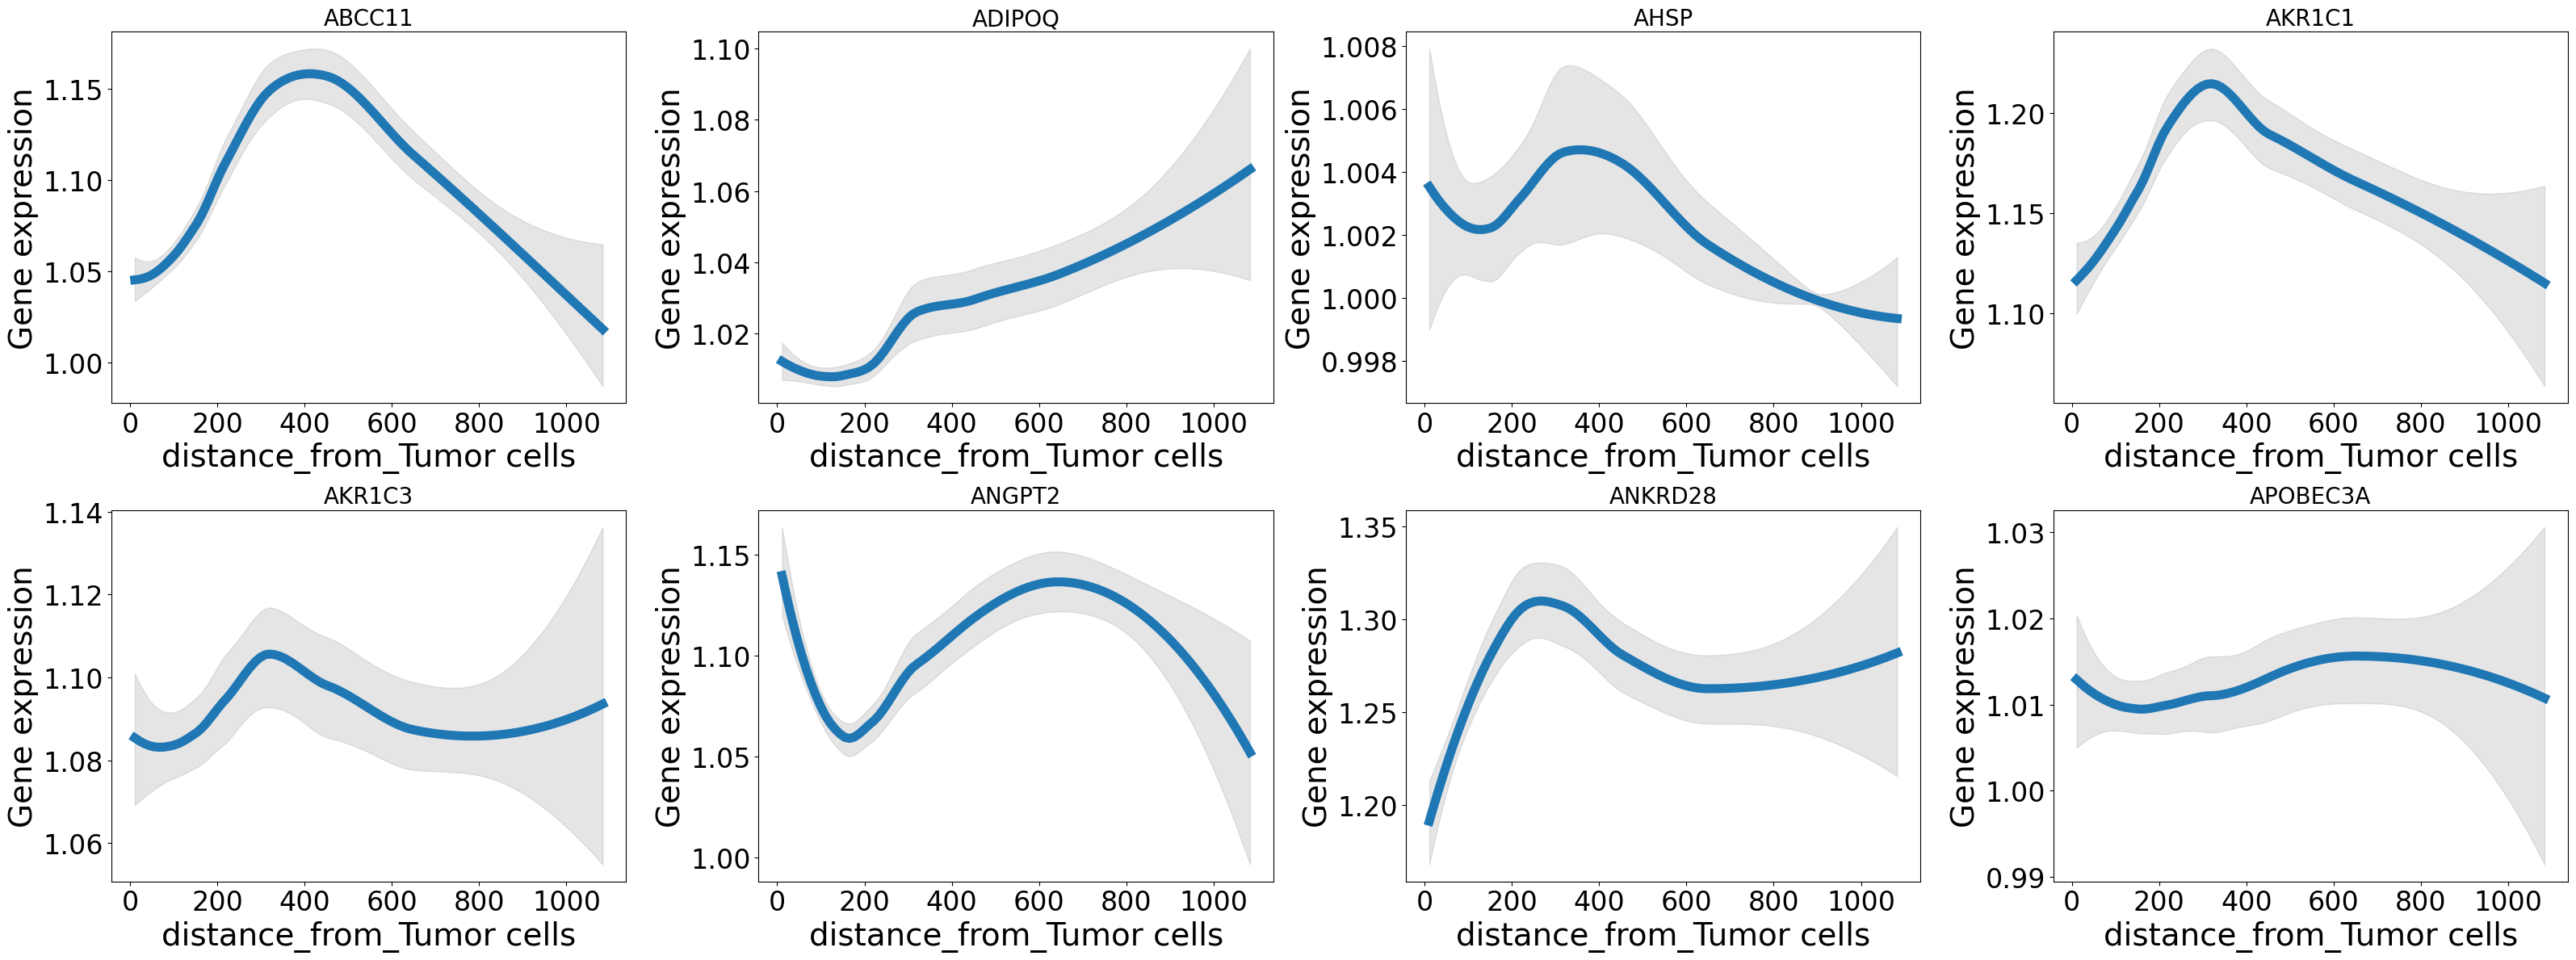

In [49]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=not_significant_genes[:8],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   )

Retrieve `obs_val` from .obsm.


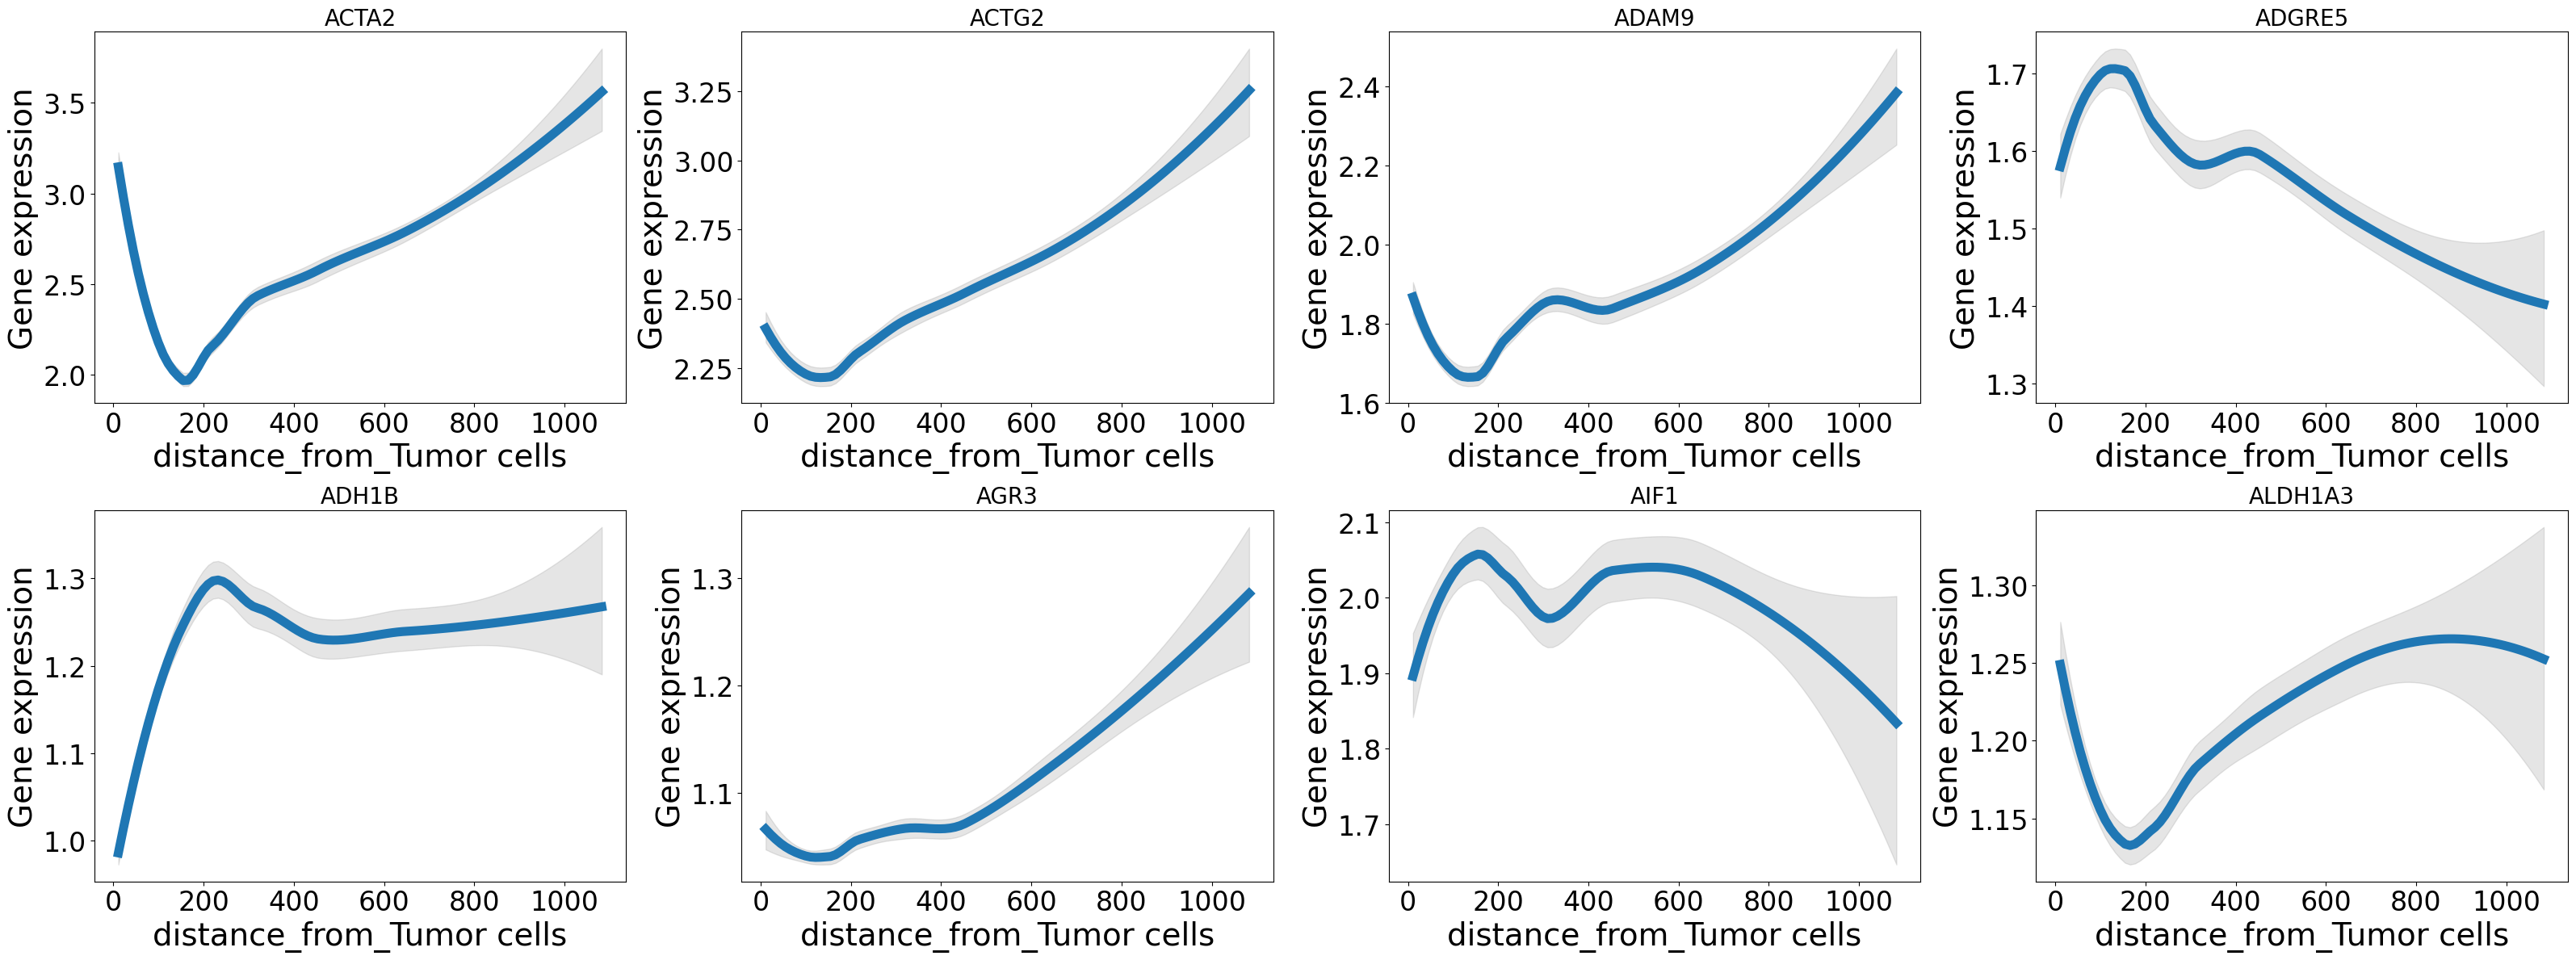

In [50]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes[:8],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   )

In [51]:
calculate_total_variation_pval(adata, "AIF1", True)

0.027242457875088284

## Use autocorrelation to select genes

Ljung-Box Test: This is often considered one of the most powerful tests for detecting autocorrelation in time series data, especially when testing multiple lags simultaneously. It is widely used in practice and is robust for various sample sizes.

In [52]:
import statsmodels.api as sm

#load data series
data = sm.datasets.sunspots.load_pandas().data

#view first ten rows of data series
data[:5]

YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0

In [54]:
from statsmodels.tsa.arima.model import ARIMA

In [55]:
#fit ARMA model to dataset
res = ARIMA(data["SUNACTIVITY"], (1,1)).fit(disp=-1)

#perform Ljung-Box test on residuals with lag=5
sm.stats.acorr_ljungbox(res.resid, lags=[5], return_df=True)

ValueError: A constant trend was included in the model specification, but the `exog` data already contains a column of constants.

## Clustering of patterns

In [56]:
df = expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes,
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=False, return_data=True)

Retrieve `obs_val` from .obsm.


In [58]:
df = expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes,
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True, return_data=True)

Retrieve `obs_val` from .obsm.


In [57]:
df

x    y_pred    std
key                                         
ACTA2  None 0     11.094653  3.146789  False
            1     22.145508  2.980164  False
            2     33.196363  2.825612  False
            3     44.247218  2.684409  False
            4     55.298073  2.557813  False
...                     ...       ...    ...
ZNF562 None 93  1038.824168  1.628803  False
            94  1049.875023  1.631820  False
            95  1060.925878  1.634814  False
            96  1071.976733  1.637786  False
            97  1083.027588  1.640736  False

[15092 rows x 3 columns]

In [176]:
# reshape and rename dataframe
df.index = df.index.droplevel(1)
df.index.names = ["gene", "pos"]

In [177]:
df

x    y_pred    std
gene   pos                              
ACTA2  0      11.094653  3.146789  False
       1      22.145508  2.980164  False
       2      33.196363  2.825612  False
       3      44.247218  2.684409  False
       4      55.298073  2.557813  False
...                 ...       ...    ...
ZNF562 93   1038.824168  1.628803  False
       94   1049.875023  1.631820  False
       95   1060.925878  1.634814  False
       96   1071.976733  1.637786  False
       97   1083.027588  1.640736  False

[22736 rows x 3 columns]

### Reshape data

In [178]:
import pandas as pd

In [179]:
regpivot = pd.pivot(df.reset_index(), index="pos", columns="gene", values="y_pred")

In [180]:
regpivot

gene     ACTA2     ACTG2     ADAM9    ADGRE5     ADH1B      AGR3      AIF1  \
pos                                                                          
0     3.146789  2.392529  1.867334  1.579889  0.985708  1.066525  1.896092   
1     2.980164  2.361282  1.831587  1.603033  1.013595  1.061637  1.919326   
2     2.825612  2.332844  1.799005  1.624068  1.040187  1.057201  1.940829   
3     2.684409  2.307552  1.770062  1.642653  1.065512  1.053298  1.960458   
4     2.557813  2.285739  1.745222  1.658453  1.089595  1.050007  1.978069   
..         ...       ...       ...       ...       ...       ...       ...   
93    3.462884  3.177608  2.325069  1.409733  1.263676  1.267574  1.861779   
94    3.487074  3.196144  2.339624  1.407810  1.264618  1.272105  1.855040   
95    3.511539  3.214915  2.354366  1.405958  1.265569  1.276663  1.848192   
96    3.536278  3.233920  2.369295  1.404179  1.266529  1.281248  1.841234   
97    3.561290  3.253160  2.384411  1.402472  1.267496  1.285860  1.834168   

gene    AKR1C1   ALDH1A3   ANKRD29  ...     TRIB1    TUBA4A    TUBB2B  \
pos                                 ...                                 
0     1.116352  1.249027  1.064281  ...  1.208515  1.696718  1.104494   
1     1.118831  1.233323  1.068488  ...  1.209759  1.699844  1.098039   
2     1.121457  1.218712  1.072504  ...  1.211188  1.702376  1.092116   
3     1.124295  1.205272  1.076289  ...  1.212853  1.704122  1.086776   
4     1.127407  1.193080  1.079798  ...  1.214800  1.704889  1.082071   
..         ...       ...       ...  ...       ...       ...       ...   
93    1.120888  1.257480  1.100289  ...  1.493890  1.620616  1.214126   
94    1.119412  1.256347  1.099460  ...  1.494249  1.618122  1.216212   
95    1.117925  1.255139  1.098621  ...  1.494486  1.615587  1.218291   
96    1.116426  1.253857  1.097774  ...  1.494600  1.613010  1.220362   
97    1.114916  1.252500  1.096918  ...  1.494590  1.610392  1.222426   

gene     USP53     VOPP1       VWF      WARS      ZEB1      ZEB2    ZNF562  
pos                                                                         
0     1.214843  2.043518  1.335813  2.094275  2.218891  3.195398  1.401919  
1     1.222464  2.059973  1.323125  2.044854  2.148555  3.178828  1.392091  
2     1.229918  2.075116  1.311638  1.998333  2.082646  3.162654  1.383184  
3     1.237188  2.088844  1.301245  1.955006  2.021644  3.146866  1.375325  
4     1.244258  2.101057  1.291840  1.915164  1.966022  3.131452  1.368640  
..         ...       ...       ...       ...       ...       ...       ...  
93    1.369184  2.011803  1.255705  1.782269  1.952262  2.611603  1.628803  
94    1.366523  2.013812  1.247406  1.781745  1.961370  2.615232  1.631820  
95    1.363773  2.015966  1.239011  1.781133  1.970652  2.619196  1.634814  
96    1.360933  2.018267  1.230523  1.780433  1.980109  2.623497  1.637786  
97    1.358004  2.020715  1.221942  1.779645  1.989742  2.628134  1.640736  

[98 rows x 232 columns]

## Calculate distance matrix from regression lines

Normalization/Z-scoring necessary to make distance measure independent of expression scale.

In [194]:
from dtaidistance import dtw, clustering
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
from insitupy import CustomPalettes
import seaborn as sns

### Perform standardization by z-scoring

In [183]:
norm = stats.zscore(regpivot.T, axis=1)

### Choose color palette

In [186]:
cpal = CustomPalettes()

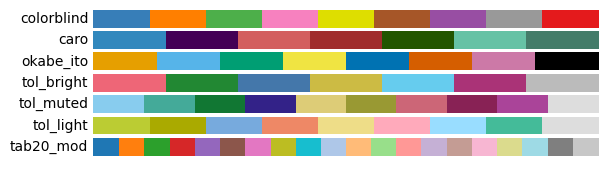

In [187]:
cpal.show_all()

In [188]:
# choose colormap
cmap = cpal.colorblind

### Calculate distance using Dynamic Time Warping and perform hierarchical clustering
https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html

In [189]:
# calculate distance matrix
dm = dtw.distance_matrix(norm.values, use_mp=True, use_c=True)
dm = pd.DataFrame(dm, index=norm.index, columns=norm.index)

### Hierarchical clustering
model = clustering.LinkageTree(dtw.distance_matrix, dists_options={'use_mp': True, 'use_c': True})
cluster_id = model.fit(norm.values)

# get linkage
Z = model.linkage

### Select distance threshold for clustering

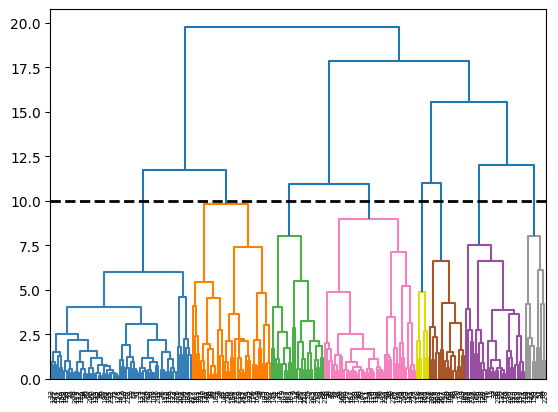

In [192]:
dist_thresh = 10

fig, ax = plt.subplots(1,1)
set_link_color_palette(cmap.colors)
dn = dendrogram(Z, color_threshold=dist_thresh, ax=ax, )
ax.axhline(y=dist_thresh, c="k", linewidth=2, linestyle="dashed")
#plt.savefig("figures/zonated_genes/dendrogram-pattern_clustering.pdf", bbox_inches="tight")
plt.show()

### Extract clusters

In [193]:
# get clusters
clusters = pd.Series(fcluster(Z, t=dist_thresh, criterion='distance'), index=dm.columns, name="cluster")

# map colors to clusters
lut = dict(zip(sorted(clusters.unique()), cmap.colors))
clustercolors = clusters.map(lut)

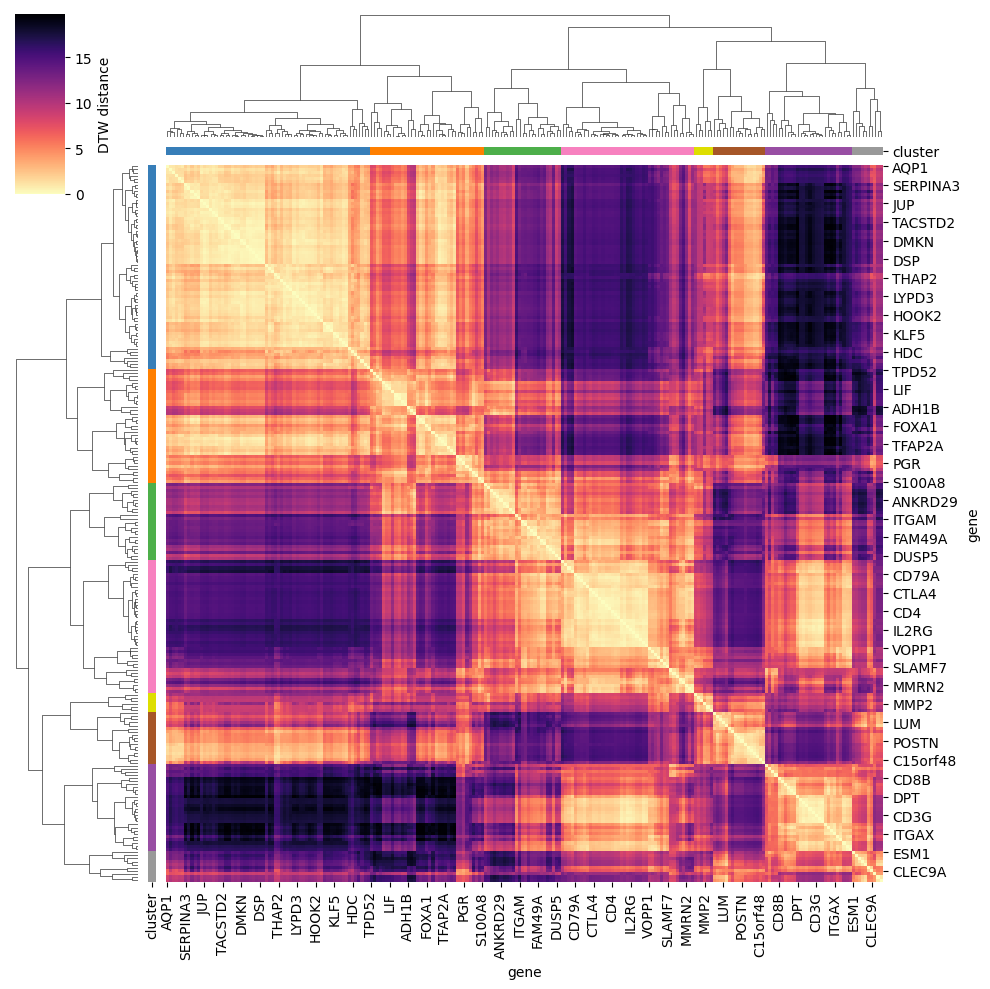

In [195]:
sns.clustermap(dm,
               cmap='magma_r',
               row_linkage=Z, col_linkage=Z,
               row_colors=clustercolors,
               col_colors=clustercolors,
               dendrogram_ratio=0.15, colors_ratio=0.01,
               cbar_kws={
                   'label': 'DTW distance',
               }
              )

#plt.savefig("figures/zonated_genes/heatmap_pattern-clustering.pdf", bbox_inches="tight")
plt.show()

In [196]:
clustercounts = pd.DataFrame(clusters.value_counts()).sort_index()
clustercounts.index.names = ["cluster"]
clustercounts.columns = ["counts"]

C:\Users\ge37voy\AppData\Local\Temp\ipykernel_9076\1440509162.py:2: UserWarning: The palette list has more values (9) than needed (8), which may not be intended.
  sns.barplot(data=clustercounts.reset_index(), x="cluster", y="counts", palette=cmap.colors, ax=ax)


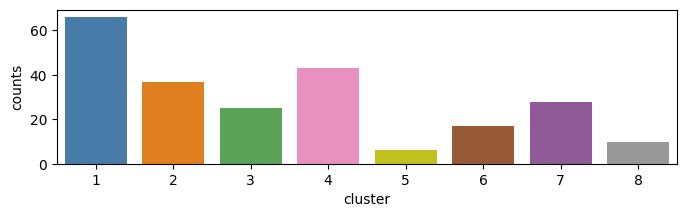

In [197]:
fig, ax = plt.subplots(1,1,figsize=(8,2))
sns.barplot(data=clustercounts.reset_index(), x="cluster", y="counts", palette=cmap.colors, ax=ax)
#plt.savefig("figures/zonated_genes/barplot_clusters.pdf", bbox_inches="tight")
plt.show()

## Plot genes per cluster

In [203]:
cc = clusters.unique()
for c in cc:
    genes = clusters.index[clusters == c]
    expr_along_obs_val(adata, keys=genes, obs_val=("distance_from", "Tumor cells"),
                             max_cols=6, stderr=True, figsize=(8,4), title_fontsize=40,
                             save_only=True,
                             savepath="figures/zonated_genes/lineplot_cluster-patterning_cluster{}.pdf".format(c)
                            )

Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster6.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster1.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster7.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster2.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster3.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster4.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster8.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster5.pdf
Saved.


In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes[:8],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   )

## Generate mean regression line per cluster

In [198]:
from sklearn.preprocessing import minmax_scale

In [199]:
# scale
norm_minmax = pd.DataFrame(minmax_scale(norm, axis=1), index=norm.index, columns=norm.columns) * 100

# add cluster information
df = pd.merge(left=norm_minmax, right=clusters, left_index=True, right_index=True)

# reshape to long format
df = df.reset_index().melt(id_vars=["gene", "cluster"], var_name="pos", value_name="expression [%]")

# scale position between 0 and 1
df["pos"] = df["pos"] / df["pos"].max()

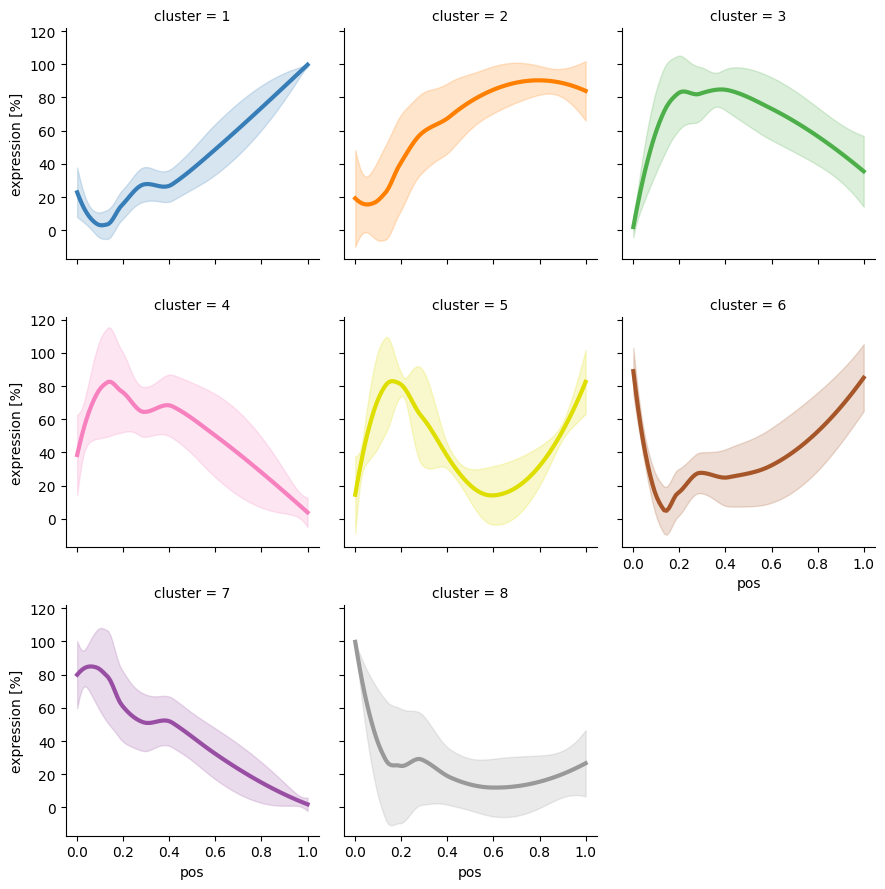

In [200]:
g = sns.FacetGrid(df, col="cluster", hue="cluster", palette=cmap.colors, col_wrap=3)
g.map(sns.lineplot, "pos", "expression [%]", ci="sd", linewidth=3)

#plt.savefig("figures/zonated_genes/lineplot_centerline-per-cluster.pdf", bbox_inches="tight")
plt.show()

## Autocorrelation function

In [ ]:
xd.show()

In [ ]:
#define data
x = [22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]

import statsmodels.api as sm

#calculate autocorrelations
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

In [ ]:
#define data
x = [22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]

import statsmodels.api as sm

#calculate autocorrelations
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

In [ ]:
sm.tsa.acf(x, nlags=5, fft=False)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962,
       0.03102625])

In [ ]:
sm.tsa.acf(x, nlags=5, fft=True)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962,
       0.03102625])

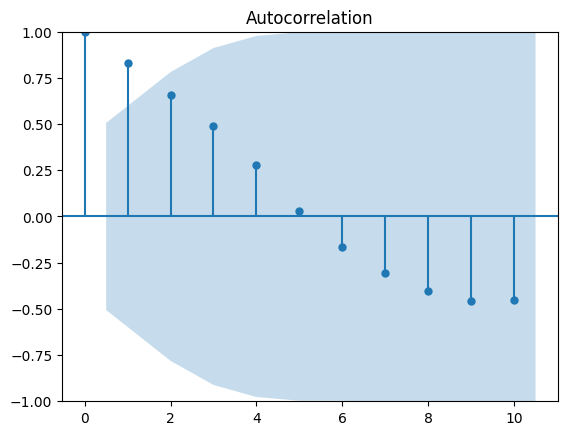

In [ ]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(x, lags=10)
plt.show()

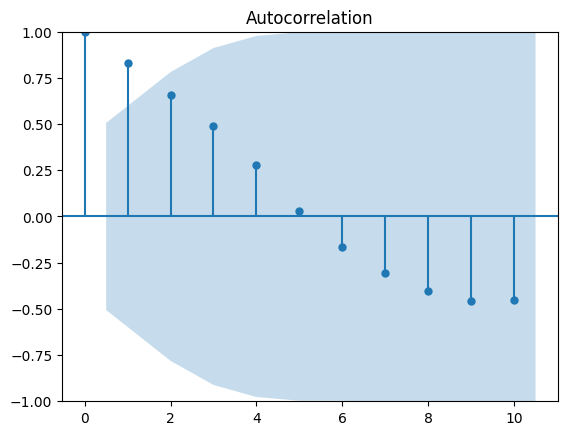

In [ ]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(x, lags=10, fft=True)
plt.show()

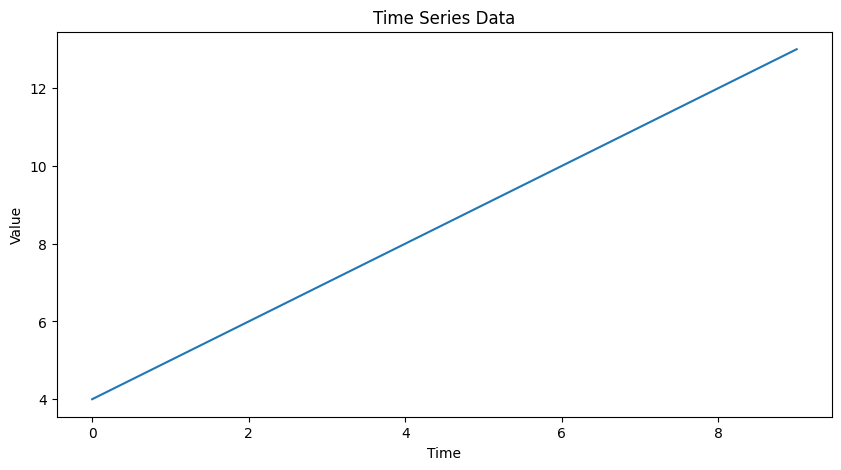

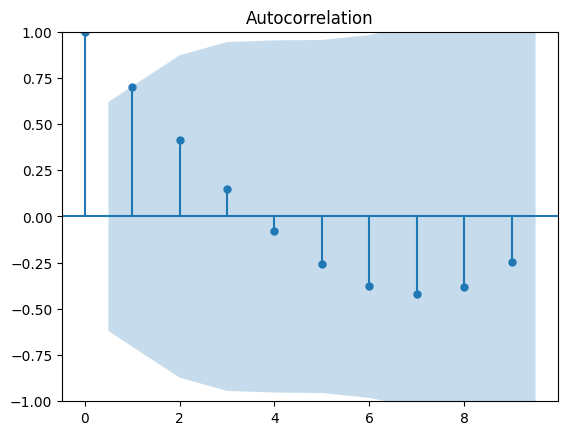

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 9 must be < 5.

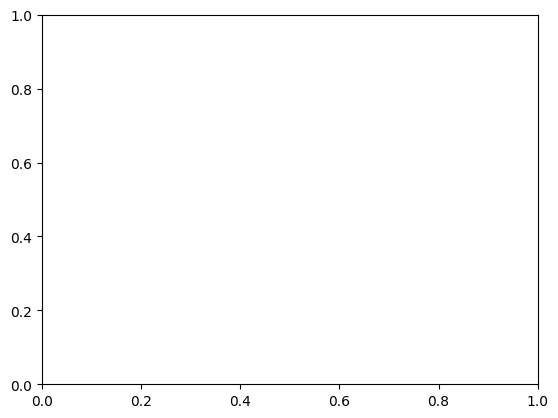

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, adfuller, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example time series data
time_series_data = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(time_series_data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

# ACF and PACF plots
plot_acf(time_series_data, lags=9)
plt.show()

plot_pacf(time_series_data, lags=9)
plt.show()

# Augmented Dickey-Fuller test
adf_result = adfuller(time_series_data)
print('ADF Statistic:', adf_result)
print('p-value:', adf_result)

# Ljung-Box test
lb_test = q_stat(acf(time_series_data, nlags=9, fft=False)[1:], len(time_series_data))
print('Ljung-Box Q-statistic:', lb_test)
print('p-values:', lb_test)
